In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [4]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Flavors.xlsx", encoding = 'unicode_escape')

In [5]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l1,label_l2,label_l3,label_l4,label_l5
0,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Brandy,Not assigned,R71,Flavors,40614069,Flavor Cherry Brandy Bottle 5kg,...,N001/Not assigned,0010/#,0010/Not assigned,447.85,447.85,Flavors,Fla/ Sweet,NaN,NaN,NaN
1,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Other,Not assigned,R71,Flavors,43692564,Flavor Pinacolada 55577-DO Givaudan BDZ,...,N001/Not assigned,0047/#,0047/Not assigned,52680.73,7701.62,Flavors,Fla/ Sweet,NaN,NaN,NaN
2,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43770855,FlavorWhiskeyBourbonGIV AY8652126KshrNGM,...,N001/Not assigned,0042/#,0042/Not assigned,43650.60,43355.09,Flavors,Fla/ Sweet,NaN,NaN,NaN
3,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43842799,Flavor Wine Powder GIV TL-937-491-1,...,N001/Not assigned,0042/#,0042/Not assigned,121079.53,119888.26,Flavors,Fla/ Sweet,NaN,NaN,NaN
4,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43885774,Flavor Hazelnut Liquid IFF SN378872,...,N001/Not assigned,0051/#,0051/Not assigned,125580.00,17856.29,Flavors,Fla/ Sweet,NaN,NaN,NaN


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [7]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [8]:
df.label_l2.value_counts()

Fla/ Sweet     4470
Fla/ Savory    2845
Name: label_l2, dtype: int64

In [9]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [10]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [11]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 4681 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 1171 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 1463 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [14]:
all_col = list(X_train.columns)

In [15]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [16]:
from keras.utils import to_categorical

# LSTM Model 

In [17]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 20)            137600    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 186,202
Trainable params: 186,202
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [18]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9955
Valid Accuracy:  0.8967
Testing Accuracy:  0.8995


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

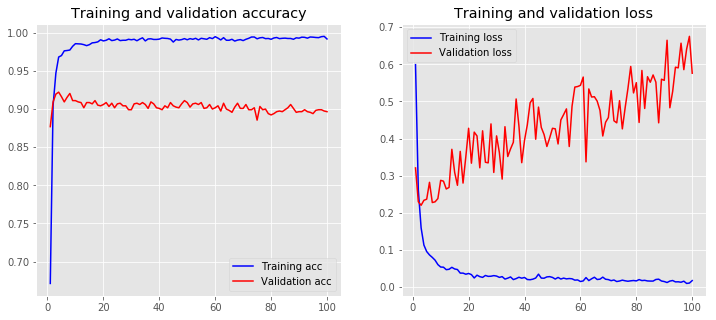

In [20]:
plot_history(history)

# Hyperparameter Tuning

In [17]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# # model.add(layers.Flatten())
# # model.add(layers.Dense(10, activation='relu'))
# # model.add(layers.Dense(3, activation='sigmoid'))
# model.add(layers.SpatialDropout1D(0.2))
# model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [19]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_lstm=100, dropout = 0.2, recurrent_dropout=0.2):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_dense, activation=activation))
#     model.add(layers.Dense(3, activation='sigmoid'))

    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(n_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [19]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [25, 32, 40], 
          'epochs': [10,12,15],
          'learning_rate': [0.01, 0.001, 0.0005],
          'embedding_dim' : [10,15,20,25,30],
          'n_lstm' : [50,70,100,120],
          'dropout' : [0.1,0.15,0.2,0.25,0.3], 
          'recurrent_dropout' : [0.1,0.15,0.2,0.25,0.3]
         }

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [21]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [22]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..

Epoch 1/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.6683 - accuracy: 0.5952
Epoch 2/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.3928 - accuracy: 0.8494
Epoch 3/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.2492 - accuracy: 0.9157
Epoch 4/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1795 - accuracy: 0.9465
Epoch 5/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1450 - accuracy: 0.9551
Epoch 6/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1334 - accuracy: 0.9619
Epoch 7/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1149 - accuracy: 0.9663
Epoch 8/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1095 - accuracy: 0.9673
Epoch 9/10
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1015 - accuracy: 0.9692
Epoch 10/10
3120/3120 [==============================] - 1s 2

3120/3120 [==============================] - 3s 1ms/step - loss: 0.1577 - accuracy: 0.9497
Epoch 6/12
3120/3120 [==============================] - 3s 1ms/step - loss: 0.1379 - accuracy: 0.9596
Epoch 7/12
3120/3120 [==============================] - 3s 1ms/step - loss: 0.1310 - accuracy: 0.9635
Epoch 8/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1176 - accuracy: 0.9676
Epoch 9/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1035 - accuracy: 0.9705
Epoch 10/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.0901 - accuracy: 0.9756
Epoch 11/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.0827 - accuracy: 0.9744
Epoch 12/12
3120/3120 [==============================] - 1s 215us/step
Epoch 1/12
3121/3121 [==============================] - 4s 1ms/step - loss: 0.6650 - accuracy: 0.6049
Epoch 2/12
3121/3121 [==============================] - 4s 1ms/step - loss: 0.4162 - accuracy: 0.8414
Epoch 3/12
3121/3121

3120/3120 [==============================] - 3s 845us/step - loss: 0.0922 - accuracy: 0.9696
Epoch 6/10
3120/3120 [==============================] - 3s 848us/step - loss: 0.0811 - accuracy: 0.9747
Epoch 7/10
3120/3120 [==============================] - 3s 853us/step - loss: 0.0754 - accuracy: 0.9756
Epoch 8/10
3120/3120 [==============================] - 3s 848us/step - loss: 0.0650 - accuracy: 0.9801
Epoch 9/10
3120/3120 [==============================] - 3s 872us/step - loss: 0.0631 - accuracy: 0.9814
Epoch 10/10
3120/3120 [==============================] - 1s 188us/step
Epoch 1/10
3121/3121 [==============================] - 3s 1ms/step - loss: 0.6774 - accuracy: 0.5992
Epoch 2/10
3121/3121 [==============================] - 3s 867us/step - loss: 0.4420 - accuracy: 0.7943
Epoch 3/10
3121/3121 [==============================] - 3s 882us/step - loss: 0.1856 - accuracy: 0.9388
Epoch 4/10
3121/3121 [==============================] - 3s 865us/step - loss: 0.1260 - accuracy: 0.9638
Epoch 

3120/3120 [==============================] - 4s 1ms/step - loss: 0.6776 - accuracy: 0.5926
Epoch 2/15
3120/3120 [==============================] - 3s 882us/step - loss: 0.5258 - accuracy: 0.7394
Epoch 3/15
3120/3120 [==============================] - 3s 929us/step - loss: 0.2454 - accuracy: 0.9167
Epoch 4/15
3120/3120 [==============================] - 3s 913us/step - loss: 0.1766 - accuracy: 0.9465
Epoch 5/15
3120/3120 [==============================] - 3s 925us/step - loss: 0.1309 - accuracy: 0.9641
Epoch 6/15
3120/3120 [==============================] - 3s 917us/step - loss: 0.1366 - accuracy: 0.9609
Epoch 7/15
3120/3120 [==============================] - 3s 947us/step - loss: 0.1143 - accuracy: 0.9705
Epoch 8/15
3120/3120 [==============================] - 3s 968us/step - loss: 0.0976 - accuracy: 0.9702
Epoch 9/15
3120/3120 [==============================] - 3s 930us/step - loss: 0.0743 - accuracy: 0.9772
Epoch 10/15
3120/3120 [==============================] - 3s 935us/step - loss

3121/3121 [==============================] - 4s 1ms/step - loss: 0.1452 - accuracy: 0.9625
Epoch 6/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0940 - accuracy: 0.9785
Epoch 7/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0784 - accuracy: 0.9817
Epoch 8/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0646 - accuracy: 0.9833
Epoch 9/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0593 - accuracy: 0.9865
Epoch 10/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0490 - accuracy: 0.9881
Epoch 11/12
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0605 - accuracy: 0.9853
Epoch 12/12
3121/3121 [==============================] - 1s 209us/step
Epoch 1/12
3120/3120 [==============================] - 3s 982us/step - loss: 0.6788 - accuracy: 0.5878
Epoch 2/12
3120/3120 [==============================] - 2s 708us/step - loss: 0.4583 - accuracy: 0.8045
Epoch 3/12
3120/

3121/3121 [==============================] - 3s 1ms/step - loss: 0.0451 - accuracy: 0.9888
Epoch 10/10
3121/3121 [==============================] - 1s 227us/step
Epoch 1/15
3120/3120 [==============================] - 3s 1ms/step - loss: 0.6681 - accuracy: 0.5984
Epoch 2/15
3120/3120 [==============================] - 3s 836us/step - loss: 0.3610 - accuracy: 0.8628
Epoch 3/15
3120/3120 [==============================] - 3s 822us/step - loss: 0.2291 - accuracy: 0.9288
Epoch 4/15
3120/3120 [==============================] - 3s 818us/step - loss: 0.1549 - accuracy: 0.9506
Epoch 5/15
3120/3120 [==============================] - 3s 829us/step - loss: 0.1268 - accuracy: 0.9635
Epoch 6/15
3120/3120 [==============================] - 3s 870us/step - loss: 0.1104 - accuracy: 0.9667
Epoch 7/15
3120/3120 [==============================] - 3s 829us/step - loss: 0.1044 - accuracy: 0.9651
Epoch 8/15
3120/3120 [==============================] - 3s 834us/step - loss: 0.0859 - accuracy: 0.9737
Epoch 9/

3121/3121 [==============================] - 2s 745us/step - loss: 0.0870 - accuracy: 0.9805
Epoch 7/10
3121/3121 [==============================] - 2s 739us/step - loss: 0.0572 - accuracy: 0.9865
Epoch 8/10
3121/3121 [==============================] - 2s 746us/step - loss: 0.0596 - accuracy: 0.9862
Epoch 9/10
3121/3121 [==============================] - 2s 787us/step - loss: 0.0468 - accuracy: 0.9907
Epoch 10/10
3121/3121 [==============================] - 1s 171us/step
Epoch 1/12
3120/3120 [==============================] - 3s 1ms/step - loss: 0.6782 - accuracy: 0.5926
Epoch 2/12
3120/3120 [==============================] - 2s 773us/step - loss: 0.4966 - accuracy: 0.7478
Epoch 3/12
3120/3120 [==============================] - 2s 758us/step - loss: 0.2533 - accuracy: 0.9157
Epoch 4/12
3120/3120 [==============================] - 2s 765us/step - loss: 0.1880 - accuracy: 0.9429
Epoch 5/12
3120/3120 [==============================] - 2s 761us/step - loss: 0.1425 - accuracy: 0.9571
Epoch 

3121/3121 [==============================] - 2s 741us/step - loss: 0.0397 - accuracy: 0.9913
Epoch 9/12
3121/3121 [==============================] - 2s 728us/step - loss: 0.0605 - accuracy: 0.9865
Epoch 10/12
3121/3121 [==============================] - 2s 760us/step - loss: 0.0371 - accuracy: 0.9926
Epoch 11/12
3121/3121 [==============================] - 2s 775us/step - loss: 0.0348 - accuracy: 0.9933
Epoch 12/12
3121/3121 [==============================] - 1s 168us/step
Epoch 1/15
3120/3120 [==============================] - 4s 1ms/step - loss: 0.6471 - accuracy: 0.6176
Epoch 2/15
3120/3120 [==============================] - 2s 768us/step - loss: 0.3172 - accuracy: 0.8811
Epoch 3/15
3120/3120 [==============================] - 2s 776us/step - loss: 0.1843 - accuracy: 0.9439
Epoch 4/15
3120/3120 [==============================] - 2s 761us/step - loss: 0.1350 - accuracy: 0.9596
Epoch 5/15
3120/3120 [==============================] - 2s 763us/step - loss: 0.1160 - accuracy: 0.9641
Epoc

3121/3121 [==============================] - 5s 1ms/step - loss: 0.0659 - accuracy: 0.9801
Epoch 10/15
3121/3121 [==============================] - 4s 1ms/step - loss: 0.0622 - accuracy: 0.9827
Epoch 11/15
3121/3121 [==============================] - 4s 1ms/step - loss: 0.0498 - accuracy: 0.9814
Epoch 12/15
3121/3121 [==============================] - 3s 1ms/step - loss: 0.0493 - accuracy: 0.9859
Epoch 13/15
3121/3121 [==============================] - 4s 1ms/step - loss: 0.0511 - accuracy: 0.9837
Epoch 14/15
3121/3121 [==============================] - 4s 1ms/step - loss: 0.0468 - accuracy: 0.9862
Epoch 15/15
3121/3121 [==============================] - 1s 232us/step
Epoch 1/15
3121/3121 [==============================] - 5s 2ms/step - loss: 0.6422 - accuracy: 0.6395
Epoch 2/15
3121/3121 [==============================] - 4s 1ms/step - loss: 0.3043 - accuracy: 0.9010
Epoch 3/15
3121/3121 [==============================] - 3s 1ms/step - loss: 0.1517 - accuracy: 0.9523
Epoch 4/15
3121/3

3120/3120 [==============================] - 3s 946us/step - loss: 0.0952 - accuracy: 0.9705
Epoch 9/12
3120/3120 [==============================] - 3s 996us/step - loss: 0.0900 - accuracy: 0.9724
Epoch 10/12
3120/3120 [==============================] - 3s 1ms/step - loss: 0.0787 - accuracy: 0.9795
Epoch 11/12
3120/3120 [==============================] - 3s 954us/step - loss: 0.0683 - accuracy: 0.9837
Epoch 12/12
3120/3120 [==============================] - 1s 240us/step
Epoch 1/12
3121/3121 [==============================] - 4s 1ms/step - loss: 0.6754 - accuracy: 0.5956
Epoch 2/12
3121/3121 [==============================] - 3s 924us/step - loss: 0.4135 - accuracy: 0.8225
Epoch 3/12
3121/3121 [==============================] - 3s 959us/step - loss: 0.2127 - accuracy: 0.9343
Epoch 4/12
3121/3121 [==============================] - 3s 931us/step - loss: 0.1678 - accuracy: 0.9503
Epoch 5/12
3121/3121 [==============================] - 3s 935us/step - loss: 0.1401 - accuracy: 0.9606
Epoch 

3121/3121 [==============================] - 1s 360us/step
Epoch 1/12
3120/3120 [==============================] - 6s 2ms/step - loss: 0.6425 - accuracy: 0.6202
Epoch 2/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.3760 - accuracy: 0.8590
Epoch 3/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.2395 - accuracy: 0.9196
Epoch 4/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1916 - accuracy: 0.9449
Epoch 5/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1498 - accuracy: 0.9583
Epoch 6/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1350 - accuracy: 0.9577
Epoch 7/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1229 - accuracy: 0.9657
Epoch 8/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1124 - accuracy: 0.9689
Epoch 9/12
3120/3120 [==============================] - 4s 1ms/step - loss: 0.1042 - accuracy: 0.9702
Epoch 10/12
3120/3120 [

In [23]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.29489453490588735 and Best Params:  {'recurrent_dropout': 0.25, 'n_lstm': 100, 'learning_rate': 0.001, 'epochs': 12, 'embedding_dim': 10, 'dropout': 0.25, 'batch_size': 32, 'activation': 'relu'}


## Fit Best Model

In [20]:
model = create_model(learning_rate=0.001, activation='relu', embedding_dim=10, n_lstm=100, dropout = 0.25, recurrent_dropout=0.25)

In [21]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=17,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=32)

In [22]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9885
Valid Accuracy:  0.9129
Testing Accuracy:  0.9166


In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

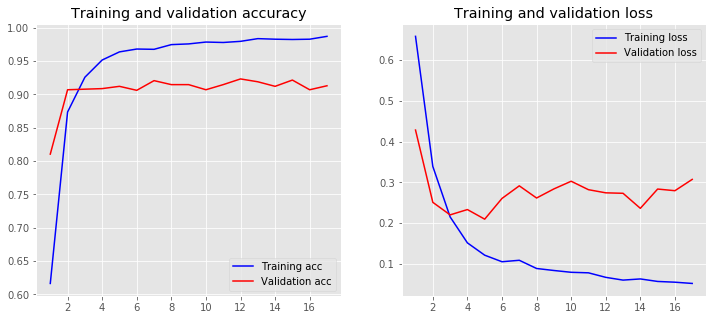

In [24]:
plot_history(history)

# Model Evaluation: Test Data

In [25]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9166097044944763


Confusion matrix, without normalization


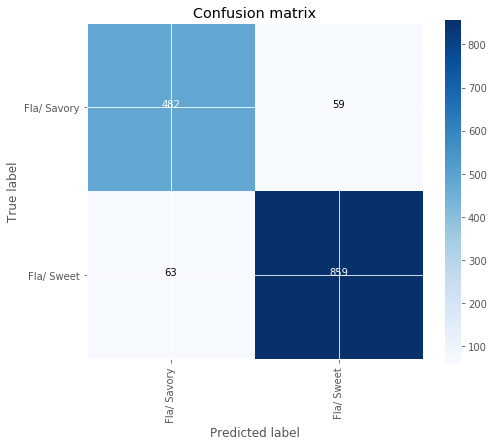

In [26]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [27]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.8213582243716521

In [28]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,Fla/ Savory,0.884404,0.890943,0.887661,541
1,Fla/ Sweet,0.935730,0.931670,0.933696,922


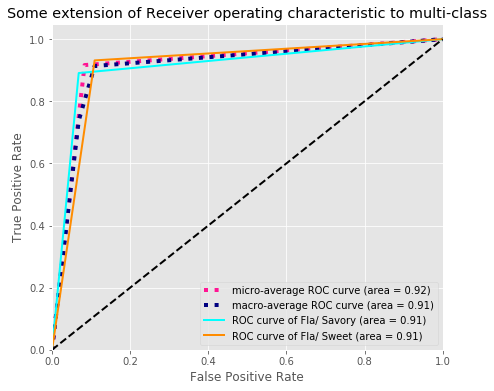

In [30]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.88


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.88')

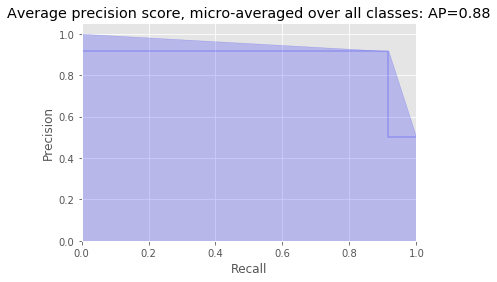

In [32]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

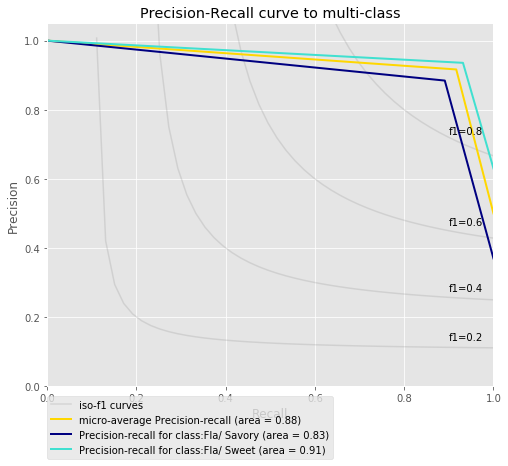

In [33]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()